# 1. IMPORTING

In [1]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sb
import os

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from fast_ml.feature_selection import get_duplicate_features
from fast_ml.feature_selection import get_constant_features

# importing ROC-AUC score to valuate models
from sklearn.metrics import roc_auc_score

# importing ROC curve to visualize ROC curve
from sklearn.metrics import roc_curve

# confusion matrix to show TP, TN, FP, FN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# classification report to describe model accuracy
from sklearn.metrics import classification_report

In [2]:
#import dataset
df = pd.read_csv("../data/source/dataset.csv")

# 2. SPLITTING

In [3]:
# data on which we base
X = df.drop(columns=['target'])

# data which we predict
y = df['target']

In [4]:
# getting train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# getting test and validation sets
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, stratify=y_test, test_size=0.3, random_state=42
)

In [5]:
# checking shapes of X's
print(X.shape, X_train.shape, X_test.shape, X_val.shape)

(50000, 300) (35000, 300) (10500, 300) (4500, 300)


In [6]:
# checking shapes of y's
print(y.shape, y_train.shape, y_test.shape, y_val.shape)

(50000,) (35000,) (10500,) (4500,)


# EXPORTING

In [7]:
# exporting data
relative_path = "../data/validation"

if not os.path.exists(relative_path):
    os.makedirs(relative_path)

X_train.to_csv(relative_path + '/train_X.csv', encoding='utf-8')
X_test.to_csv(relative_path + '/test_X.csv', encoding='utf-8')
X_val.to_csv(relative_path + '/val_X.csv', encoding='utf-8')

y_train.to_csv(relative_path + '/train_y.csv', encoding='utf-8')
y_test.to_csv(relative_path + '/test_y.csv', encoding='utf-8')
y_val.to_csv(relative_path + '/val_y.csv', encoding='utf-8')

# 3. DATASET INFO

In [8]:
# first five rows
X_train.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_291,var_292,var_293,var_294,var_295,var_296,var_297,var_298,var_299,var_300
13889,0,0,0.0,2.88,0.0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0.0,0.0
18173,0,0,0.0,2.91,0.0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0.0,0.0
11779,0,0,0.0,2.82,0.0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0.0,0.0
28068,0,0,0.0,5.82,0.0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0.0,0.0
26232,0,0,0.0,0.00,0.0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0.0,0.0


In [9]:
y_train.head()

13889    0
18173    0
11779    0
28068    0
26232    0
Name: target, dtype: int64

In [10]:
# shape
X_train.shape

(35000, 300)

In [11]:
# info
X_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35000 entries, 13889 to 47738
Data columns (total 300 columns):
 #    Column   Non-Null Count  Dtype  
---   ------   --------------  -----  
 0    var_1    35000 non-null  int64  
 1    var_2    35000 non-null  int64  
 2    var_3    35000 non-null  float64
 3    var_4    35000 non-null  float64
 4    var_5    35000 non-null  float64
 5    var_6    35000 non-null  int64  
 6    var_7    35000 non-null  int64  
 7    var_8    35000 non-null  int64  
 8    var_9    35000 non-null  int64  
 9    var_10   35000 non-null  int64  
 10   var_11   35000 non-null  float64
 11   var_12   35000 non-null  float64
 12   var_13   35000 non-null  float64
 13   var_14   35000 non-null  int64  
 14   var_15   35000 non-null  int64  
 15   var_16   35000 non-null  float64
 16   var_17   35000 non-null  float64
 17   var_18   35000 non-null  float64
 18   var_19   35000 non-null  int64  
 19   var_20   35000 non-null  int64  
 20   var_21   35000 non-nul

In [12]:
# description
X_train.describe()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_291,var_292,var_293,var_294,var_295,var_296,var_297,var_298,var_299,var_300
count,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,3.500000e+04,35000.000000,35000.000000,35000.000000,35000.000000,...,35000.000000,35000.000000,35000.000000,35000.0,35000.000000,35000.000000,35000.0,35000.000000,35000.000000,3.500000e+04
mean,0.002229,0.000029,16.754658,3.152425,623.621139,5.714286e+03,0.000257,0.033257,0.000257,0.000257,...,0.006686,0.083938,0.010114,0.0,0.128229,0.085200,0.0,0.003343,15.130148,5.643619e+03
std,0.113369,0.005345,1426.650119,2.745780,10899.867683,7.559181e+05,0.027774,0.314115,0.027774,0.035856,...,0.143274,1.107691,0.212500,0.0,0.608109,0.603805,0.0,0.082914,952.917261,4.711153e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00
50%,0.000000,0.000000,0.000000,2.850000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00
75%,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00
max,9.000000,1.000000,207901.336500,35.280000,445500.000000,1.000000e+08,3.000000,3.000000,3.000000,6.000000,...,6.000000,74.520000,12.000000,0.0,6.000000,33.000000,0.0,3.000000,134666.681100,2.857673e+06


# 4. TRANSFORMATIONS

## 4.1. NAs

In [13]:
def nan_handler(df):    
    # medians per column
    medians_train = {}
    
    # iterate over every column
    for column in df.columns:
        # calculate median for given column
        medians_train[column] = df[column].median()
        
        # replace NAs with median
        df[column].fillna(medians_train[column], inplace=True)
        
    print("NAs handled")
    return df 

## 4.2. OUTLIERS

In [14]:
from scipy.stats import zscore

def outliers_handler(df):
    # calculate z-scores for each column
    z_scores = np.abs(zscore(df))
    
    # set a threshold for the z-score values
    threshold = 2.5
    
    # define the means_train dictionary
    means_train = {}

    # loop over each column in X_train
    for column in df.columns:
        # ientify the rows where the z-score exceeds the threshold  
        outliers = z_scores[column] > threshold

        # calculate the mean of the column excluding outliers
        means_train[column] = np.nanmean(df[column][~outliers])

        # replace values that exceed the threshold
        if outliers.any():
            # values in current columns with outliers
            values = df[column].values
            
            # mean with no outliers
            mean = means_train[column]
            
            # True is written where outlier is
            mask = outliers
            
            # iterate through every outlier in column
            for i in np.where(mask)[0]:
                if values[i] > mean:
                    # find last value greater than mean and within 2.5 std
                    replacement_candidates = values[(values > mean) & ~outliers]
                    if len(replacement_candidates) > 0:
                        replacement = sorted(replacement_candidates)[-1]
                    else:
                        replacement = mean
                else:
                    # find last value less than mean and within 2.5 std
                    replacement_candidates = values[(values < mean) & ~outliers]
                    if len(replacement_candidates) > 0:
                        replacement = sorted(replacement_candidates)[0]
                    else:
                        replacement = mean
                df.iloc[i, df.columns.get_loc(column)] = replacement
                
    print("outliers handled")
    return df 

## 4.3. STANDARIZATION

In [15]:
def standarization_handler(df):    
    scaler = StandardScaler()
    scaler.fit(df)
    scaled = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled, columns=df.columns)
    
    print("standarization handled")
    return scaled_df  

# 5. FEATURE NUMBER REDUCTION

## 5.1. DUPLICATES

In [16]:
def drop_duplicate_features(df):
    # retrieve duplicate features object
    duplicate_features = get_duplicate_features(df)
    
    # retrieve names of duplicate features
    duplicate_features = duplicate_features[duplicate_features['Desc'] == 'Duplicate Values']['feature2'].tolist()
    
    # remove duplicates
    df.drop(columns = duplicate_features, inplace=True)
    
    print("duplicate features dropped")
    return df

## 5.2. CONSTANTS

In [17]:
def drop_constant_features(df):
    # retrieve constant features object
    constant_features = get_constant_features(df)
    
    # retrieve names of constant features
    constant_features = constant_features[constant_features['Perc'] > 98]['Var'].tolist()
    
    # remove constant features
    df.drop(columns = constant_features, inplace=True)
    
    print("constant features dropped")
    return df

## 5.3. CORRELATED

In [18]:
def drop_correlated_features(df):
    # calculate correlation
    corr = df.corr(method="spearman").abs()
    
    # retrieve correlation data
    upper_triangle = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    
    # retrieve highly correlated features' names
    corr_features = []
    for col in upper_triangle:
        if any(upper_triangle[col] > 0.8): 
            corr_features.append(col)

    # remove correlated features
    corr_features = pd.Series(corr_features)
    df.drop(columns = corr_features, inplace=True)
    
    print("correlated features dropped")
    return df

# 6. MODELS 

## 6.1. PREPARE

In [19]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

nan_handler_transf = FunctionTransformer(nan_handler)
outliers_handler_transf = FunctionTransformer(outliers_handler)
standarization_handler_transf = FunctionTransformer(standarization_handler)
drop_duplicate_features_transf = FunctionTransformer(drop_duplicate_features)
drop_constant_features_transf = FunctionTransformer(drop_constant_features)
drop_correlated_features_transf = FunctionTransformer(drop_correlated_features)

prepare = Pipeline([
    ("nan_handling", nan_handler_transf),
    ("outliers_handling", outliers_handler_transf),
    ("standarization_handling", standarization_handler_transf),
    ("dropping_duplicate_features", drop_duplicate_features_transf),
    ("dropping_constant_features", drop_constant_features_transf),
    ("dropping_correlated_features", drop_correlated_features_transf)
])

In [20]:
def prepare_dataset(df, consistent_cols = []):
    df = nan_handler(df)
    df = outliers_handler(df)
    df = standarization_handler(df)
    
    if len(consistent_cols) == 0:
        df = drop_duplicate_features(df)
        df = drop_constant_features(df)
        df = drop_correlated_features(df)
    else:
        to_drop = filter(lambda i: i not in consistent_cols, df.columns)
        df.drop(columns = list(to_drop), inplace=True)
        print("columns consistent")
    
    return df

In [21]:
if False:
    X_train = prepare.fit_transform(X_train)
    X_val = prepare.transform(X_val)
else:
    X_train = prepare_dataset(X_train)
    X_val = prepare_dataset(X_val, X_train.columns)

NAs handled
outliers handled
standarization handled
duplicate features dropped
constant features dropped
correlated features dropped
NAs handled
outliers handled
standarization handled
columns consistent


In [22]:
X_train.shape

(35000, 34)

In [23]:
X_val.shape

(4500, 34)

## 6.2 EVALUATING MODELS

In [31]:
def model_evaluation(model, X_df, y_df):
    y_pred_proba = model.predict_proba(X_df)
    y_pred = model.predict(X_df)
    # roc curve for models
    fpr_model, tpr_model, thresh_model = roc_curve(y_df, y_pred_proba[:,1], pos_label=1)

    # roc curve for tpr = fpr 
    random_probs = [0 for i in range(len(y_df))]
    p_fpr, p_tpr, _ = roc_curve(y_df, random_probs, pos_label=1)

    plt.style.use('seaborn')

    # plot roc curves
    plt.plot(fpr_model, tpr_model, linestyle='--',color='orange', label='Random Forest')
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')
    plt.savefig('ROC',dpi=300)
    plt.show();
    
    # auc scores
    auc_score_model = roc_auc_score(y_df, y_pred_proba[:,1])

    print("Classification report: ", "\n" , classification_report(y_df, y_pred))
    print("Random Forest Score: ", model.score(X_df,y_df))
    print("AUC score: ", auc_score_model)
    
    ConfusionMatrixDisplay.from_estimator(model, X_df, y_df)
    plt.show()

### 6.2.1. K Neighbors model

In [32]:
from sklearn.neighbors import KNeighborsClassifier

KN_model = KNeighborsClassifier(n_neighbors=4)
KN_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

### EVALUATION

F:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


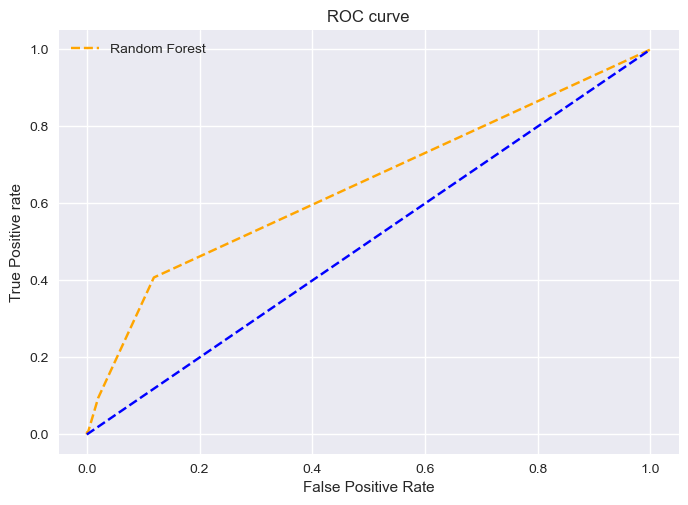

Classification report:  
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      4321
           1       0.10      0.01      0.01       179

    accuracy                           0.96      4500
   macro avg       0.53      0.50      0.49      4500
weighted avg       0.93      0.96      0.94      4500



F:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Random Forest Score:  0.9584444444444444
AUC score:  0.6459392159118971


F:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


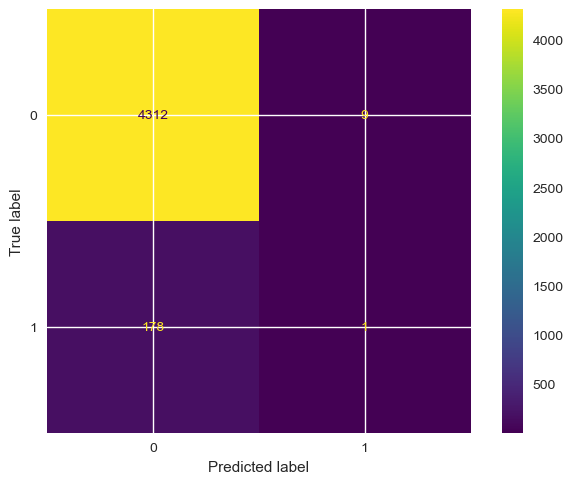

In [33]:
model_evaluation(KN_model, X_val, y_val)

### 6.2.2. Logistic Regression model

In [34]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)

LogisticRegression()

### EVALUATION

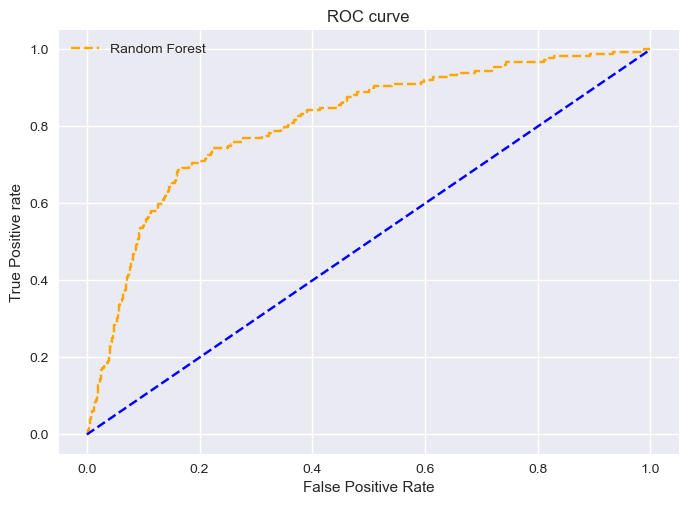

Classification report:  
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      4321
           1       0.00      0.00      0.00       179

    accuracy                           0.96      4500
   macro avg       0.48      0.50      0.49      4500
weighted avg       0.92      0.96      0.94      4500

Random Forest Score:  0.9597777777777777
AUC score:  0.8106790405179848


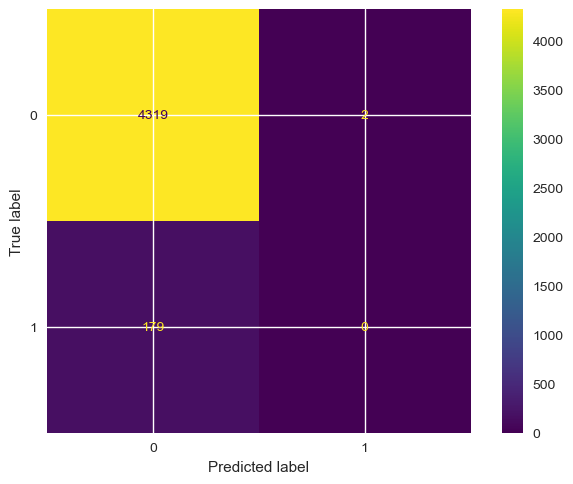

In [35]:
model_evaluation(LR_model, X_val, y_val)

### 6.2.3. Random Forest model

In [36]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [37]:
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=2)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=2)

### EVALUATION

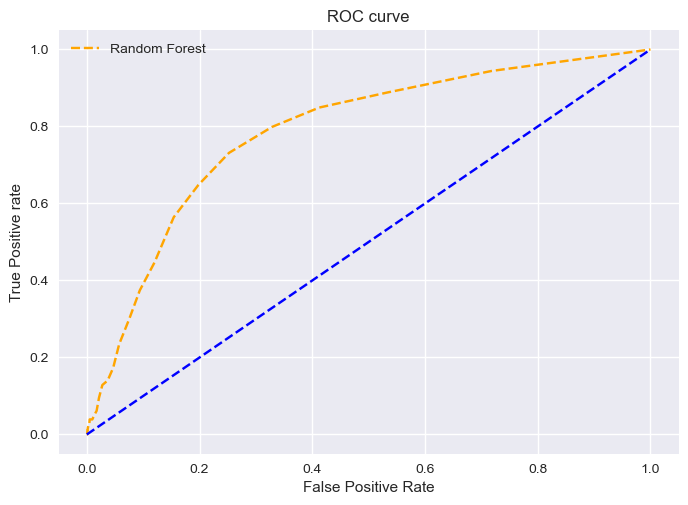

F:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report:  
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      4321
           1       0.00      0.00      0.00       179

    accuracy                           0.96      4500
   macro avg       0.48      0.50      0.49      4500
weighted avg       0.92      0.96      0.94      4500

Random Forest Score:  0.9602222222222222
AUC score:  0.7855232145466018


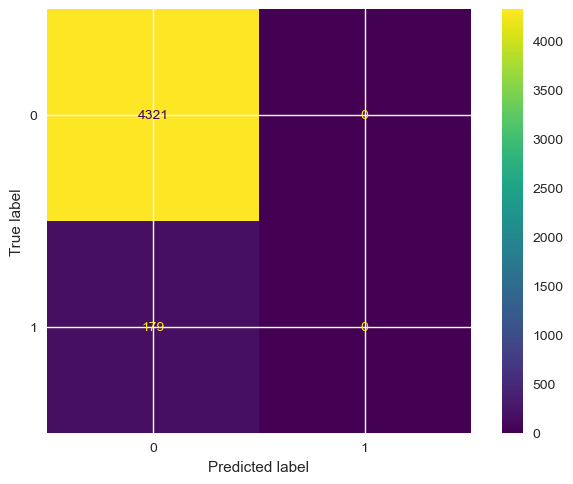

In [38]:
model_evaluation(rf_model, X_val, y_val)

### VERIFYING FEATURE IMPORTANCE IN RANDOM FOREST MODEL

In [53]:
# Get feature importances and sort them in descending order
importances = rf_model.feature_importances_
sorted_indices = importances.argsort()[::-1]
columns = X_train.columns

# Identify non-predictive columns
non_predictive_cols = []
for i in sorted_indices:
    if importances[i] < 0.05:
        non_predictive_cols.append(columns[i])
        
# Remove non-predictive columns
reduced_X_train = X_train.drop(columns=non_predictive_cols)

# Train a new random forest classifier on the reduced dataset
rf_model_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_reduced.fit(reduced_X_train, y_train)

RandomForestClassifier(random_state=42)

### 2ND EVALUATION OF RANDOM FOREST MODEL

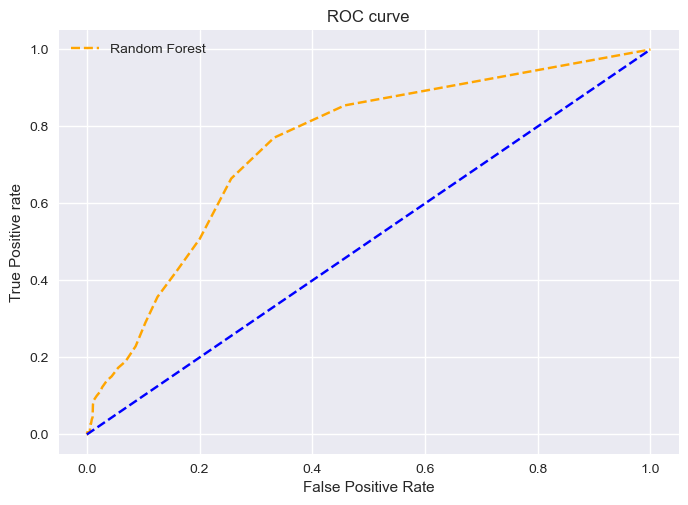

F:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report:  
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      4321
           1       0.00      0.00      0.00       179

    accuracy                           0.96      4500
   macro avg       0.48      0.50      0.49      4500
weighted avg       0.92      0.96      0.94      4500

Random Forest Score:  0.9602222222222222
AUC score:  0.7483299050111253


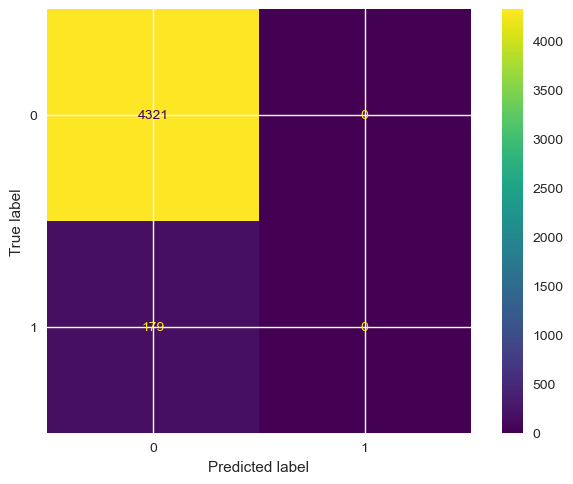

In [54]:
reduced_X_val = X_val.drop(non_predictive_cols, axis=1)

model_evaluation(rf_model_reduced, reduced_X_val, y_val)

### 6.2.4. Gradient Boosting model

In [41]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification

In [42]:
# train a Gradient Boosting classifier
GB_clf = GradientBoostingClassifier(random_state=42)
GB_clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

### EVALUATION

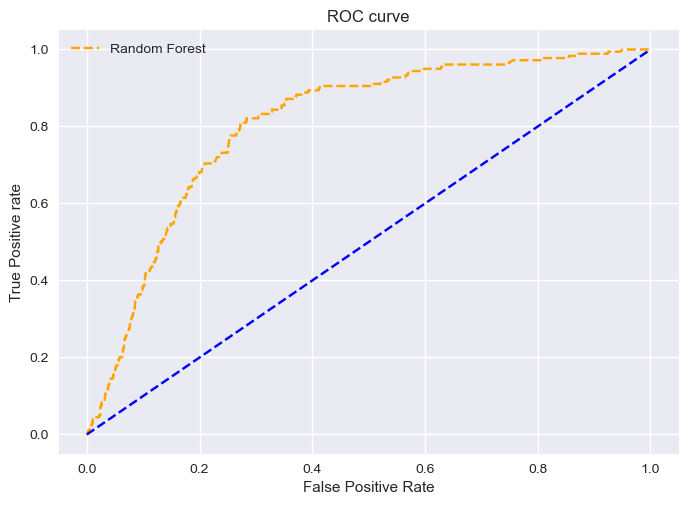

Classification report:  
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      4321
           1       0.00      0.00      0.00       179

    accuracy                           0.96      4500
   macro avg       0.48      0.50      0.49      4500
weighted avg       0.92      0.96      0.94      4500

Random Forest Score:  0.9597777777777777
AUC score:  0.8068824591865891


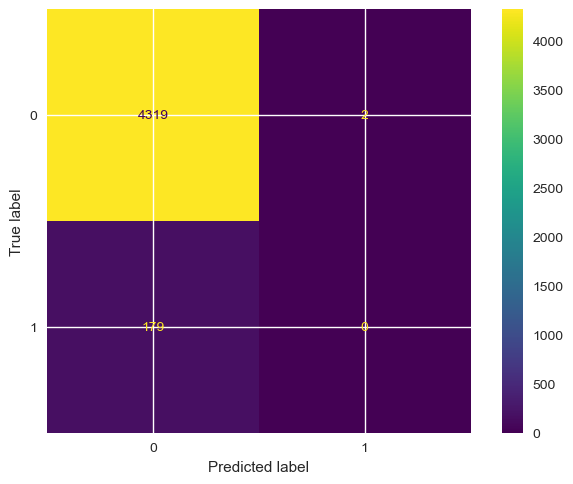

In [43]:
model_evaluation(GB_clf, X_val, y_val)

### 6.2.5. XGBoost model

In [44]:
from xgboost import XGBClassifier
from sklearn.datasets import make_classification

# train an XGBoost classifier
XGB_model = XGBClassifier(random_state=42)
XGB_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

### EVALUATION

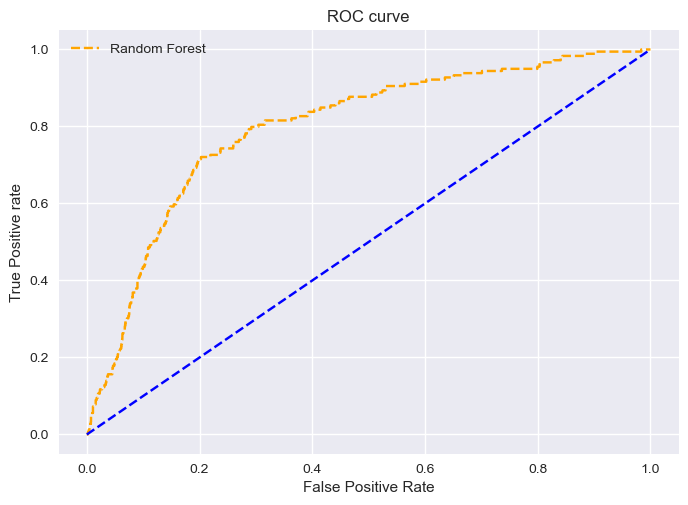

Classification report:  
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      4321
           1       0.00      0.00      0.00       179

    accuracy                           0.96      4500
   macro avg       0.48      0.50      0.49      4500
weighted avg       0.92      0.96      0.94      4500

Random Forest Score:  0.9597777777777777
AUC score:  0.7973098768001923


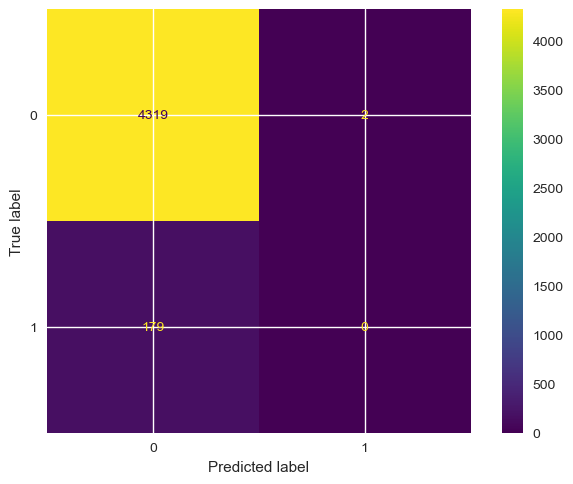

In [46]:
model_evaluation(XGB_model, X_val, y_val)

## 6.3. Hyperparameters tuning

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [56]:
KN_model

KNeighborsClassifier(n_neighbors=4)

# EXPORTING

In [ ]:
# exporting preprocessed dataset to csv
relative_path = "../data/preprocessed"

if not os.path.exists(relative_path):
    os.makedirs(relative_path)
    
X_train.to_csv(relative_path + '/train_dataset.csv', encoding='utf-8')